In [1]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

# Helper function for visualization.
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt


def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()


def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()

2.2.0+cpu


# Introduction: Hands-on Graph Neural Networks

Recently, deep learning on graphs has emerged to one of the hottest research fields in the deep learning community.
Here, **Graph Neural Networks (GNNs)** aim to generalize classical deep learning concepts to irregular structured data (in contrast to images or texts) and to enable neural networks to reason about objects and their relations.

This is done by following a simple **neural message passing scheme**, where node features $\mathbf{x}_v^{(\ell)}$ of all nodes $v \in \mathcal{V}$ in a graph $\mathcal{G} = (\mathcal{V}, \mathcal{E})$ are iteratively updated by aggregating localized information from their neighbors $\mathcal{N}(v)$:

$$
\mathbf{x}_v^{(\ell + 1)} = f^{(\ell + 1)}_{\theta} \left( \mathbf{x}_v^{(\ell)}, \left\{ \mathbf{x}_w^{(\ell)} : w \in \mathcal{N}(v) \right\} \right)
$$

This tutorial will introduce you to some fundamental concepts regarding deep learning on graphs via Graph Neural Networks based on the **[PyTorch Geometric (PyG) library](https://github.com/rusty1s/pytorch_geometric)**.
PyTorch Geometric is an extension library to the popular deep learning framework [PyTorch](https://pytorch.org/), and consists of various methods and utilities to ease the implementation of Graph Neural Networks.

Following [Kipf et al. (2017)](https://arxiv.org/abs/1609.02907), let's dive into the world of GNNs by looking at a simple graph-structured example, the well-known [**Zachary's karate club network**](https://en.wikipedia.org/wiki/Zachary%27s_karate_club). This graph describes a social network of 34 members of a karate club and documents links between members who interacted outside the club. Here, we are interested in detecting communities that arise from the member's interaction.

PyTorch Geometric provides an easy access to this dataset via the [`torch_geometric.datasets`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets) subpackage:

In [19]:
from torch_geometric.datasets import KarateClub

dataset = KarateClub()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print("dataset", dataset)

Dataset: KarateClub():
Number of graphs: 1
Number of features: 34
Number of classes: 4
dataset KarateClub()


After initializing the [`KarateClub`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.KarateClub) dataset, we first can inspect some of its properties.
For example, we can see that this dataset holds exactly **one graph**, and that each node in this dataset is assigned a **34-dimensional feature vector** (which uniquely describes the members of the karate club).
Furthermore, the graph holds exactly **4 classes**, which represent the community each node belongs to.

Let's now look at the underlying graph in more detail:

In [36]:
data = dataset[0]  # Get the first graph object.

print(data)
print('==============================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
Number of nodes: 34
Number of edges: 156
Average node degree: 4.59
Number of training nodes: 4
Training node label rate: 0.12
Has isolated nodes: False
Has self-loops: False
Is undirected: True


Each graph in PyTorch Geometric is represented by a single [`Data`](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.Data) object, which holds all the information to describe its graph representation.
We can print the data object anytime via `print(data)` to receive a short summary about its attributes and their shapes:
```
Data(edge_index=[2, 156], x=[34, 34], y=[34], train_mask=[34])
```
We can see that this `data` object holds 4 attributes:
(1) The `edge_index` property holds the information about the **graph connectivity**, *i.e.*, a tuple of source and destination node indices for each edge.
PyG further refers to (2) **node features** as `x` (each of the 34 nodes is assigned a 34-dim feature vector), and to (3) **node labels** as `y` (each node is assigned to exactly one class).
(4) There also exists an additional attribute called `train_mask`, which describes for which nodes we already know their community assigments.
In total, we are only aware of the ground-truth labels of 4 nodes (one for each community), and the task is to infer the community assignment for the remaining nodes.

The `data` object also provides some **utility functions** to infer some basic properties of the underlying graph.
For example, we can easily infer whether there exists isolated nodes in the graph (*i.e.* there exists no edge to any node), whether the graph contains self-loops (*i.e.*, $(v, v) \in \mathcal{E}$), or whether the graph is undirected (*i.e.*, for each edge $(v, w) \in \mathcal{E}$ there also exists the edge $(w, v) \in \mathcal{E}$).

Let us now inspect the `edge_index` property in more detail:

In [4]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

edge_index = data.edge_index
print(edge_index.t())

<IPython.core.display.Javascript object>

tensor([[ 0,  1],
        [ 0,  2],
        [ 0,  3],
        [ 0,  4],
        [ 0,  5],
        [ 0,  6],
        [ 0,  7],
        [ 0,  8],
        [ 0, 10],
        [ 0, 11],
        [ 0, 12],
        [ 0, 13],
        [ 0, 17],
        [ 0, 19],
        [ 0, 21],
        [ 0, 31],
        [ 1,  0],
        [ 1,  2],
        [ 1,  3],
        [ 1,  7],
        [ 1, 13],
        [ 1, 17],
        [ 1, 19],
        [ 1, 21],
        [ 1, 30],
        [ 2,  0],
        [ 2,  1],
        [ 2,  3],
        [ 2,  7],
        [ 2,  8],
        [ 2,  9],
        [ 2, 13],
        [ 2, 27],
        [ 2, 28],
        [ 2, 32],
        [ 3,  0],
        [ 3,  1],
        [ 3,  2],
        [ 3,  7],
        [ 3, 12],
        [ 3, 13],
        [ 4,  0],
        [ 4,  6],
        [ 4, 10],
        [ 5,  0],
        [ 5,  6],
        [ 5, 10],
        [ 5, 16],
        [ 6,  0],
        [ 6,  4],
        [ 6,  5],
        [ 6, 16],
        [ 7,  0],
        [ 7,  1],
        [ 7,  2],
        [ 

By printing `edge_index`, we can understand how PyG represents graph connectivity internally.
We can see that for each edge, `edge_index` holds a tuple of two node indices, where the first value describes the node index of the source node and the second value describes the node index of the destination node of an edge.

This representation is known as the **COO format (coordinate format)** commonly used for representing sparse matrices.
Instead of holding the adjacency information in a dense representation $\mathbf{A} \in \{ 0, 1 \}^{|\mathcal{V}| \times |\mathcal{V}|}$, PyG represents graphs sparsely, which refers to only holding the coordinates/values for which entries in $\mathbf{A}$ are non-zero.

Importantly, PyG does not distinguish between directed and undirected graphs, and treats undirected graphs as a special case of directed graphs in which reverse edges exist for every entry in `edge_index`.

We can further visualize the graph by converting it to the `networkx` library format, which implements, in addition to graph manipulation functionalities, powerful tools for visualization:

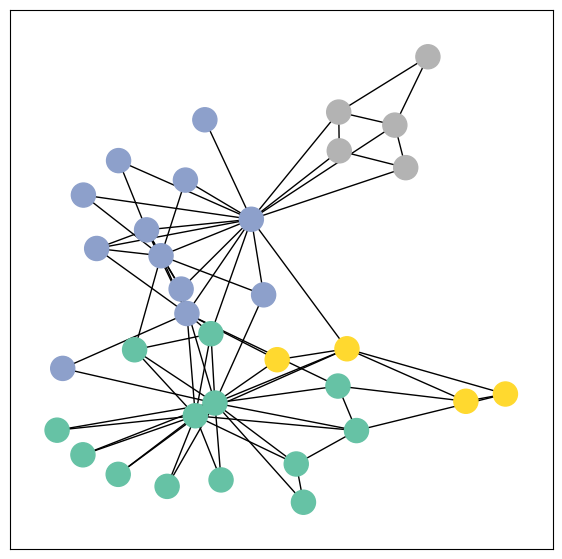

In [5]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
visualize_graph(G, color=data.y)

## Implementing Graph Neural Networks

After learning about PyG's data handling, it's time to implement our first Graph Neural Network!

For this, we will use on of the most simple GNN operators, the **GCN layer** ([Kipf et al. (2017)](https://arxiv.org/abs/1609.02907)), which is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \sum_{w \in \mathcal{N}(v) \, \cup \, \{ v \}} \frac{1}{c_{w,v}} \cdot \mathbf{x}_w^{(\ell)}
$$

where $\mathbf{W}^{(\ell + 1)}$ denotes a trainable weight matrix of shape `[num_output_features, num_input_features]` and $c_{w,v}$ refers to a fixed normalization coefficient for each edge.

PyG implements this layer via [`GCNConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv), which can be executed by passing in the node feature representation `x` and the COO graph connectivity representation `edge_index`.

With this, we are ready to create our first Graph Neural Network by defining our network architecture in a `torch.nn.Module` class:

In [14]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234)
        self.conv1 = GCNConv(dataset.num_features, 4)
        self.conv2 = GCNConv(4, 4)
        self.conv3 = GCNConv(4, 2)
        self.classifier = Linear(2, dataset.num_classes)

    def forward(self, x, edge_index):
        # print("Input shapes:")
        # print("x:", x.shape)
        # print("edge_index:", edge_index.shape)
        outputs = {}
        h = self.conv1(x, edge_index)
        h = h.tanh()
        outputs["conv1"] = h
        h = self.conv2(h, edge_index)
        h = h.tanh()
        outputs["conv2"] = h
        h = self.conv3(h, edge_index)
        h = h.tanh()  # Final GNN embedding space.
        outputs["conv3"] = h
        # Apply a final (linear) classifier.
        out = self.classifier(h)
        outputs["final"] = out
        return outputs

model = GCN()
print(model)

GCN(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)


Here, we first initialize all of our building blocks in `__init__` and define the computation flow of our network in `forward`.
We first define and stack **three graph convolution layers**, which corresponds to aggregating 3-hop neighborhood information around each node (all nodes up to 3 "hops" away).
In addition, the `GCNConv` layers reduce the node feature dimensionality to $2$, *i.e.*, $34 \rightarrow 4 \rightarrow 4 \rightarrow 2$. Each `GCNConv` layer is enhanced by a [tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html?highlight=tanh#torch.nn.Tanh) non-linearity.

After that, we apply a single linear transformation ([`torch.nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html?highlight=linear#torch.nn.Linear)) that acts as a classifier to map our nodes to 1 out of the 4 classes/communities.

We return both the output of the final classifier as well as the final node embeddings produced by our GNN.
We proceed to initialize our final model via `GCN()`, and printing our model produces a summary of all its used sub-modules.


### Embedding the Karate Club Network

Let's take a look at the node embeddings produced by our GNN.
Here, we pass in the initial node features `x` and the graph connectivity information `edge_index` to the model, and visualize its 2-dimensional embedding.

conv1 shape: [34, 4]
conv2 shape: [34, 4]
conv3 shape: [34, 2]
final shape: [34, 4]
output dictionary {'conv1': tensor([[ 0.1164,  0.0049, -0.0614, -0.1717],
        [ 0.0580, -0.0833,  0.1728, -0.1133],
        [-0.0681, -0.0407,  0.0585, -0.1726],
        [ 0.0468,  0.0352,  0.0539, -0.1076],
        [-0.1062, -0.1011, -0.0622,  0.0199],
        [ 0.0721, -0.0409, -0.0355, -0.0818],
        [ 0.0078,  0.0796,  0.0032, -0.1004],
        [ 0.0453,  0.0029,  0.1159, -0.1353],
        [ 0.0434, -0.0075,  0.1384, -0.0487],
        [-0.0846,  0.1059,  0.1063, -0.0243],
        [-0.0229,  0.0337, -0.0916, -0.0627],
        [ 0.2176,  0.1370, -0.1125, -0.1428],
        [ 0.1387,  0.0527,  0.0084,  0.0519],
        [ 0.0435,  0.1080,  0.1252, -0.0989],
        [ 0.0178, -0.0564,  0.0107,  0.0977],
        [ 0.1500,  0.0026,  0.0637,  0.1378],
        [ 0.0849,  0.0643,  0.0051, -0.1524],
        [ 0.0941, -0.1070,  0.0184,  0.0136],
        [-0.0386,  0.1403,  0.0528,  0.0901],
        [ 0.04

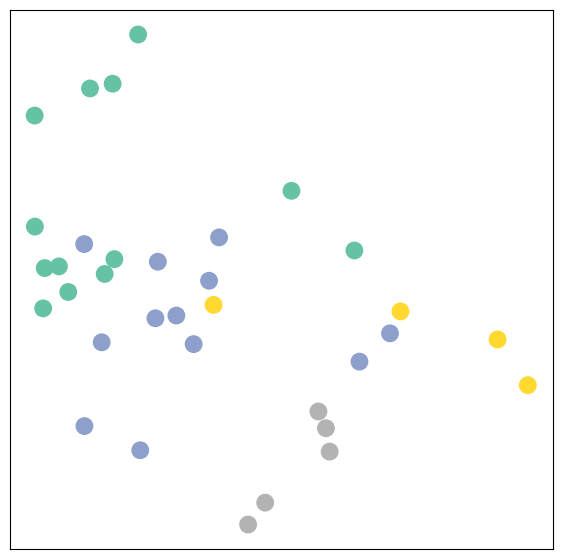

In [38]:
model = GCN()

outputs = model(data.x, data.edge_index)

print(f'conv1 shape: {list(outputs['conv1'].shape)}')
print(f'conv2 shape: {list(outputs['conv2'].shape)}')
print(f'conv3 shape: {list(outputs['conv3'].shape)}')
print(f'final shape: {list(outputs['final'].shape)}')

# the data structure to stores all intermediate data output
print("output dictionary", outputs)

visualize_embedding(outputs['conv3'], color=data.y)

Remarkably, even before training the weights of our model, the model produces an embedding of nodes that closely resembles the community-structure of the graph.
Nodes of the same color (community) are already closely clustered together in the embedding space, although the weights of our model are initialized **completely at random** and we have not yet performed any training so far!
This leads to the conclusion that GNNs introduce a strong inductive bias, leading to similar embeddings for nodes that are close to each other in the input graph.

### Training on the Karate Club Network

But can we do better? Let's look at an example on how to train our network parameters based on the knowledge of the community assignments of 4 nodes in the graph (one for each community):

Since everything in our model is differentiable and parameterized, we can add some labels, train the model and observse how the embeddings react.
Here, we make use of a semi-supervised or transductive learning procedure: We simply train against one node per class, but are allowed to make use of the complete input graph data.

Training our model is very similar to any other PyTorch model.
In addition to defining our network architecture, we define a loss critertion (here, [`CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)) and initialize a stochastic gradient optimizer (here, [`Adam`](https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam)).
After that, we perform multiple rounds of optimization, where each round consists of a forward and backward pass to compute the gradients of our model parameters w.r.t. to the loss derived from the forward pass.
If you are not new to PyTorch, this scheme should appear familar to you.
Otherwise, the PyTorch docs provide [a good introduction on how to train a neural network in PyTorch](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#define-a-loss-function-and-optimizer).

Note that our semi-supervised learning scenario is achieved by the following line:
```
loss = criterion(out[data.train_mask], data.y[data.train_mask])
```
While we compute node embeddings for all of our nodes, we **only make use of the training nodes for computing the loss**.
Here, this is implemented by filtering the output of the classifier `out` and ground-truth labels `data.y` to only contain the nodes in the `train_mask`.

Let us now start training and see how our node embeddings evolve over time (best experienced by explicitely running the code):

In [16]:
import time
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 430})'''))

model = GCN()
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Define optimizer.

def train(data):
    optimizer.zero_grad()  # Clear gradients.
    outputs = model(data.x, data.edge_index)  # Perform a single forward pass.
    out = outputs["final"]
    h = outputs["conv3"]
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss, h

for epoch in range(401):
    print("epoch", epoch)
    loss, h = train(data)
    # if epoch % 10 == 0:
    #     visualize_embedding(h, color=data.y, epoch=epoch, loss=loss)
    #     time.sleep(0.3)

<IPython.core.display.Javascript object>

epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
epoch 31
epoch 32
epoch 33
epoch 34
epoch 35
epoch 36
epoch 37
epoch 38
epoch 39
epoch 40
epoch 41
epoch 42
epoch 43
epoch 44
epoch 45
epoch 46
epoch 47
epoch 48
epoch 49
epoch 50
epoch 51
epoch 52
epoch 53
epoch 54
epoch 55
epoch 56
epoch 57
epoch 58
epoch 59
epoch 60
epoch 61
epoch 62
epoch 63
epoch 64
epoch 65
epoch 66
epoch 67
epoch 68
epoch 69
epoch 70
epoch 71
epoch 72
epoch 73
epoch 74
epoch 75
epoch 76
epoch 77
epoch 78
epoch 79
epoch 80
epoch 81
epoch 82
epoch 83
epoch 84
epoch 85
epoch 86
epoch 87
epoch 88
epoch 89
epoch 90
epoch 91
epoch 92
epoch 93
epoch 94
epoch 95
epoch 96
epoch 97
epoch 98
epoch 99
epoch 100
epoch 101
epoch 102
epoch 103
epoch 104
epoch 105
epoch 106
epoch 107
epoch 108
epoch 109
epoch 110


As one can see, our 3-layer GCN model manages to linearly separating the communities and classifying most of the nodes correctly.

Furthermore, we did this all with a few lines of code, thanks to the PyTorch Geometric library which helped us out with data handling and GNN implementations.

## Conclusion

This concludes the first introduction into the world of GNNs and PyTorch Geometric.
In the follow-up sessions, you will learn how to achieve state-of-the-art classification results on a number of real-world graph datasets.

[Next: Node Classification with Graph Neural Networks](https://colab.research.google.com/drive/14OvFnAXggxB8vM4e8vSURUp1TaKnovzX)


In [17]:
# dummy data testing
x_dummy = torch.rand(34, 34)
print(f"x: {x_dummy.size()}")

edge_index_dummy = torch.randint(0, 34, (2, 156))  
print(f"edge_index: {edge_index_dummy.size()}")

dummy_input = (x_dummy, edge_index_dummy)
print("simulation dummy input", dummy_input)

x: torch.Size([34, 34])
edge_index: torch.Size([2, 156])
simulation dummy input (tensor([[0.5513, 0.5326, 0.5210,  ..., 0.6928, 0.1777, 0.5117],
        [0.2968, 0.0248, 0.6407,  ..., 0.3445, 0.0616, 0.5512],
        [0.6339, 0.0456, 0.5955,  ..., 0.1129, 0.3655, 0.9524],
        ...,
        [0.9045, 0.4370, 0.3895,  ..., 0.9500, 0.6982, 0.5943],
        [0.8766, 0.7747, 0.0534,  ..., 0.3393, 0.5575, 0.1521],
        [0.2504, 0.7344, 0.1587,  ..., 0.0479, 0.8856, 0.1133]]), tensor([[30, 17, 33,  6, 32,  9, 30, 13,  9,  6, 25,  6, 24, 29,  5, 12, 15, 21,
         22,  3, 18,  1,  2, 19, 11, 14, 33, 18, 17, 22, 18,  2,  3, 17, 15, 22,
         14, 22, 21,  4, 31, 19,  7, 16, 27, 23, 17, 12, 13, 14,  4,  4, 20,  5,
         26,  3, 24, 17, 30,  4, 29,  0, 14, 19,  4, 23, 13, 19, 28, 21,  0, 31,
         28, 22,  5,  4, 33,  3, 19, 12,  7, 16, 27, 32, 10, 27, 30, 26, 16, 29,
         30,  4, 13, 28,  7, 19, 11, 11, 32,  5, 28, 27, 30, 23, 33, 15, 19,  0,
         33,  0,  8,  4, 21, 10, 1

In [18]:
# python model to ONNX model
torch.onnx.export(model,               # model being run
                  dummy_input,         # model input 
                  "gnn_node_model.onnx",    # where to save the model
                  export_params=True,  # store the trained parameter weights inside the model file
                  opset_version=17,    # the ONNX version to export the model to
                #   do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['x', 'edge_index'],   # the model's input names
                  output_names=['conv1', 'conv2', 'conv3', 'final'],
                  dynamic_axes={'x': {0: 'num_nodes'},
                                'edge_index': {1: 'num_edges'},
                                'output': {0: 'batch_size'}})  # which axes should be considered dynamic)

c:\Python312\Lib\site-packages\torch\onnx\utils.py:2095: UserWarning: Provided key output for dynamic axes is not a valid input/output name
  warnings.warn(
c:\Python312\Lib\site-packages\torch\onnx\symbolic_opset9.py:5805: UserWarning: Exporting aten::index operator with indices of type Byte. Only 1-D indices are supported. In any other case, this will produce an incorrect ONNX graph.
  warnings.warn(


In [39]:
# export data from dataset
import json
def data_to_json(data):
    json_data = {}
    
    # Convert node features to a list of lists
    if data.x is not None:
        json_data['x'] = data.x.tolist()  # Assuming x is a tensor of node features
    
    # Convert edge index to a list of pairs/lists
    if data.edge_index is not None:
        edge_index_list = data.edge_index.tolist()  # Convert to [2] and then to list
        json_data['edge_index'] = edge_index_list 
    
    # Convert labels to a list
    if data.y is not None:
        json_data['y'] = data.y.tolist()  
    num_nodes = data.x.size(0)
    batch = torch.zeros(num_nodes, dtype=torch.int32)
    json_data['batch'] = batch.tolist()
    
    
    return json_data

json_data = data_to_json(dataset[0])
with open(f'karate_dataset.json', 'w') as f:
    json.dump(json_data, f, indent=4)

In [29]:
# test the ONNX model
import numpy as np

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=-1, keepdims=True)

import onnx
import onnxruntime as ort

data = dataset[0]

x = data.x.numpy().astype('float32')
edge_index = data.edge_index.numpy().astype('int64')

edge_attr = torch.ones(edge_index.shape[1], 1).numpy().astype('float32')
onnx_model_path = "gnn_node_model.onnx"
onnx_model = onnx.load(onnx_model_path)
onnx.checker.check_model(onnx_model)

ort_session = ort.InferenceSession(onnx_model_path)

ort_inputs = {
    'x': x,
    'edge_index': edge_index
}

ort_outputs = ort_session.run(None, ort_inputs)

print("ort outputs",ort_outputs)

logits = ort_outputs[0]
probs = softmax(logits)
print("probs", probs, probs.shape)
predicted_classes = logits.argmax(axis=1)

print("predicted classes", predicted_classes, predicted_classes.shape)

ort outputs [array([[ 0.21888882, -0.87259394, -0.40774065,  0.4191851 ],
       [-0.28328022, -0.8219025 ,  0.21483855,  0.7459931 ],
       [-0.6093089 , -0.13172129,  0.5720021 ,  0.4518165 ],
       [-0.17863645, -0.7157099 ,  0.09227569,  0.584933  ],
       [ 0.5584368 , -0.5849278 , -0.58971614, -0.5171014 ],
       [ 0.7253288 , -0.60371196, -0.6356263 , -0.6528916 ],
       [ 0.6935943 , -0.52191967, -0.6122532 , -0.6634492 ],
       [-0.19684511, -0.5731552 ,  0.23560037,  0.4180226 ],
       [-0.42543772,  0.15366173,  0.53525835,  0.4214682 ],
       [-0.52622545,  0.3200036 ,  0.52508074,  0.4189296 ],
       [ 0.6120007 , -0.49260002, -0.6077676 , -0.5722444 ],
       [ 0.05617806, -0.5046403 , -0.17518765,  0.2667686 ],
       [ 0.20418382, -0.5750321 , -0.19730526,  0.44353434],
       [-0.26612988, -0.37605488,  0.33457795,  0.44135386],
       [-0.45793176,  0.36236864,  0.44616485,  0.47815365],
       [-0.34749618,  0.41254157,  0.4874648 ,  0.50880986],
       [ 0.

In [30]:
# export weights of the model
import onnx
import numpy as np
import json

model = onnx.load('gnn_node_model.onnx')

weights = {}

for tensor in model.graph.initializer:
    np_array = onnx.numpy_helper.to_array(tensor)
    weights[tensor.name] = np_array.tolist()

with open('node_weights.json', 'w') as f:
    json.dump(weights, f)

In [31]:
# weights analysis
import json
import numpy as np

def extract_keys(data, keys_set=None):
    if keys_set is None:
        keys_set = set()
    
    if isinstance(data, dict):
        for key, value in data.items():
            keys_set.add(key)
            extract_keys(value, keys_set)
    elif isinstance(data, list):
        for item in data:
            extract_keys(item, keys_set)
    
    return keys_set

with open("node_weights.json", "r") as file:
    data = json.load(file)

print(data)

keys = extract_keys(data)

# print all keys in json
print("All keys:", keys)

for k in keys:
    d = np.array(data[k])
    print(k,d.shape)

# weights data file analysis
# All keys: {'conv3.bias', 'onnx::MatMul_277', 'onnx::MatMul_271', 'conv2.bias', 'classifier.weight', 'onnx::MatMul_274', 'classifier.bias', 'conv1.bias'}
# conv3.bias (2,)
# onnx::MatMul_277 (4, 2)
# onnx::MatMul_271 (34, 4)
# conv2.bias (4,)
# classifier.weight (4, 2)
# onnx::MatMul_274 (4, 4)
# classifier.bias (4,)
# conv1.bias (4,)

# intermediate data shape for each layer
# conv1 shape: [34, 4]
# conv2 shape: [34, 4]
# conv3 shape: [34, 2]
# final shape: [34, 4]

{'conv1.bias': [-0.039778850972652435, 0.00739553477615118, 0.05298786982893944, 0.030290881171822548], 'conv2.bias': [0.02054794877767563, -0.3486083745956421, 0.01034882664680481, -0.2824620306491852], 'conv3.bias': [0.5336016416549683, 0.6442952752113342], 'classifier.weight': [[-1.8559030294418335, 2.329101085662842], [-1.7800179719924927, -2.316472053527832], [2.543712854385376, 2.234900712966919], [2.4806430339813232, -2.2876639366149902]], 'classifier.bias': [0.22108545899391174, 0.30399879813194275, 0.3022165298461914, 0.3496207594871521], 'onnx::MatMul_271': [[0.9893048405647278, -1.086769938468933, -0.3226100504398346, 0.05203956738114357], [-0.6487584114074707, -1.3011393547058105, 0.657602846622467, 0.7091618776321411], [-0.6693059206008911, 0.24557778239250183, 0.8903368711471558, 0.38997209072113037], [-0.061488159000873566, -0.7953605651855469, 0.17842361330986023, 0.688416063785553], [0.6027281284332275, -0.44313284754753113, -1.0069857835769653, -0.8923645615577698], [